In [1]:
import pandas as pd

calls_long_lat = pd.read_csv('../data/clean/calls_full.csv')



In [2]:
calls_long_lat.head()

,CallDescription,Longitude,Latitude,CallDateTime
0,Sick Person,-78.164122,39.171316,2016-12-01 05:35:23
1,Falls,-78.170729,39.167610,2016-12-01 10:03:51
2,Falls,-78.159111,39.175520,2016-12-01 16:58:41
3,Sick Person,-78.186034,39.138891,2016-12-01 20:42:58
4,Sick Person,-78.165961,39.187564,2016-12-01 23:16:32


In [3]:
calls_long_lat = calls_long_lat[['Longitude', 'Latitude']]

In [4]:
calls_long_lat.head()

,Longitude,Latitude
0,-78.164122,39.171316
1,-78.170729,39.167610
2,-78.159111,39.175520
3,-78.186034,39.138891
4,-78.165961,39.187564


In [27]:
import numpy as np
from sklearn.cluster import KMeans

# Only include the two columns needed
coords = np.radians(calls_long_lat[['Longitude', 'Latitude']])

kmeans = KMeans(n_clusters=4, random_state=42).fit(coords)
calls_long_lat['cluster'] = kmeans.labels_

# Get centroids (still in radians)
centroids_rad = kmeans.cluster_centers_

# Convert back to degrees
centroids_deg = np.degrees(centroids_rad)

# Create a DataFrame — now the shape will match (4, 2)
centroid_df = pd.DataFrame(centroids_deg, columns=['Longitude', 'Latitude'])

print(centroid_df)


   Longitude   Latitude
0 -78.156878  39.186418
1 -78.168286  39.171911
2 -78.183721  39.157422
3 -78.183386  39.192184


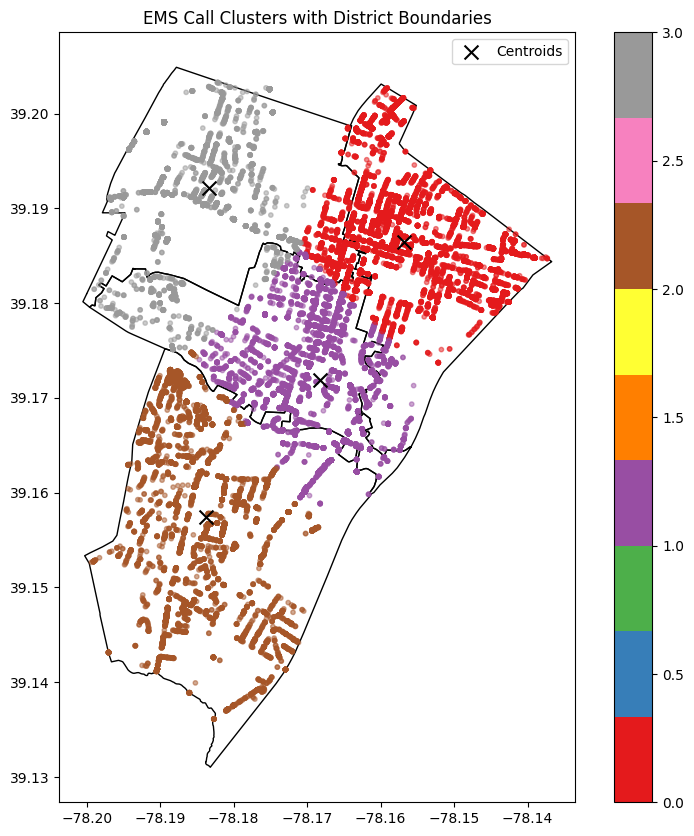

In [28]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# Load geojson boundary file
districts = gpd.read_file("../data/First_Due_Areas.geojson")

# Convert call points to GeoDataFrame
calls_gdf = gpd.GeoDataFrame(
    calls_long_lat,
    geometry=gpd.points_from_xy(calls_long_lat['Longitude'], calls_long_lat['Latitude']),
    crs="EPSG:4326"
)

# Convert centroids to GeoDataFrame (longitude comes first!)
centroid_gdf = gpd.GeoDataFrame(
    centroid_df,
    geometry=gpd.points_from_xy(centroid_df['Longitude'], centroid_df['Latitude']),
    crs="EPSG:4326"
)

# Plot everything
fig, ax = plt.subplots(figsize=(10, 10))
districts.plot(ax=ax, edgecolor='black', facecolor='none')
calls_gdf.plot(ax=ax, column='cluster', cmap='Set1', markersize=10, alpha=0.5, legend=True)
centroid_gdf.plot(ax=ax, color='black', markersize=100, marker='x', label='Centroids')

plt.title("EMS Call Clusters with District Boundaries")
plt.legend()
plt.show()
